runs/detect/result/crops/license_plate/Enter--2024-11-24_13-53-352.jpg



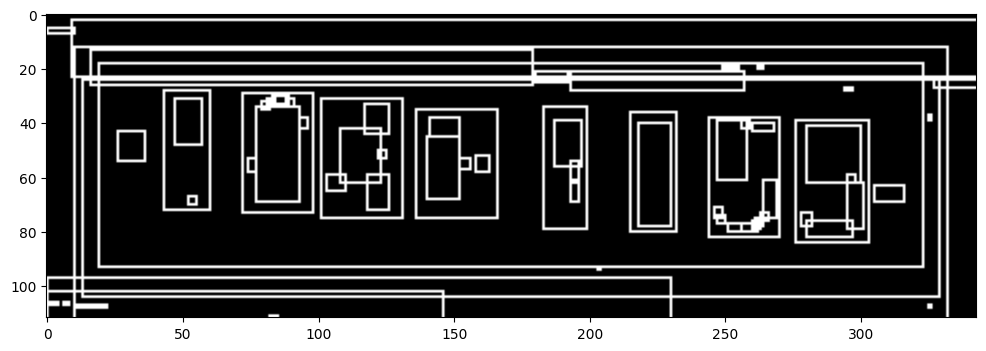

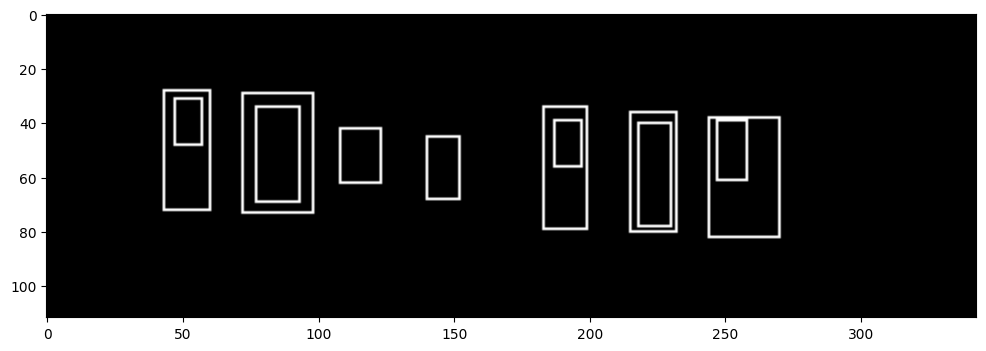

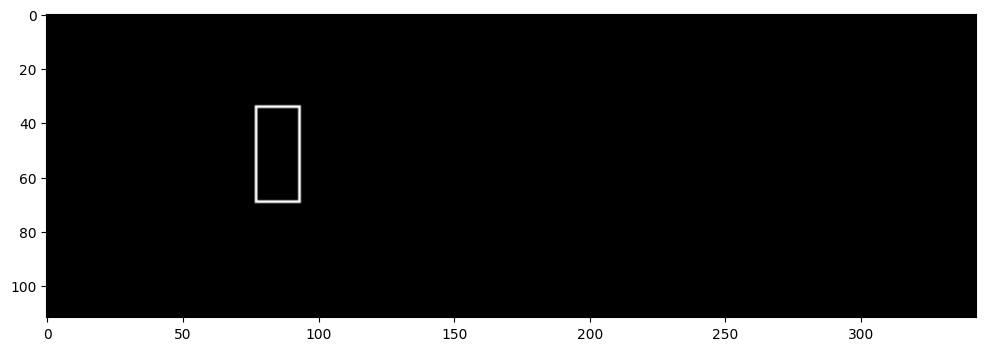

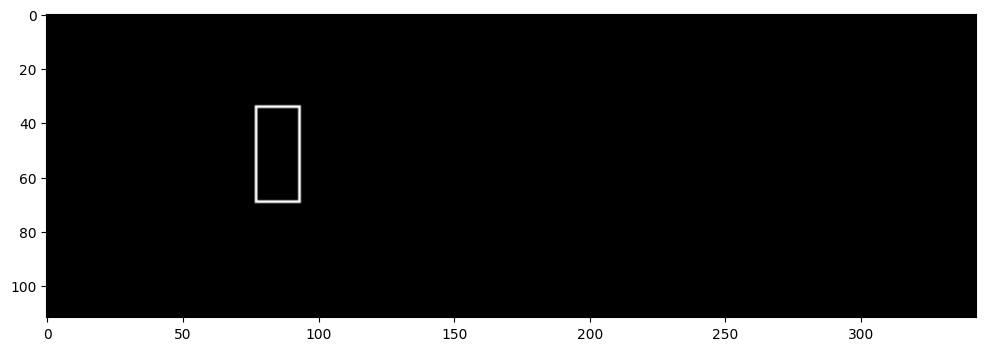

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #기기에 설치된 소프트웨어적인 문제로 인한 임시조치
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import math
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'



folder_path = 'runs/detect/result/crops/0/'

# each_file_path_and_gen_time: 각 file의 경로와, 생성 시간을 저장함
each_file_path_and_gen_time = []
for each_file_name in os.listdir(folder_path):
    # getctime: 입력받은 경로에 대한 생성 시간을 리턴
    each_file_path = folder_path + each_file_name
    each_file_gen_time = os.path.getctime(each_file_path)
    each_file_path_and_gen_time.append(
        (each_file_path, each_file_gen_time)
    )

# 가장 생성시각이 큰(가장 최근인) 파일을 리턴 
most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]
print(most_recent_file)


img = cv2.imread(most_recent_file)
img_for_crop = Image.open(most_recent_file)
height, width, channel = img.shape

# -------- Gray 이미지로 바꿔주기 -------- #
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# -------- 가우시안 Blur 필터 적용 = 부드럽게 해서 잡다한 노이즈 제거 -------- #
img_blur = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=0)

# -------- 문턱값 설정 ------- #
img_thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 11)

contours, _ = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

# -------- 생성된 Contours 정보 저장 ------- #
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
contours_dict = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x + w, y + h), color=(255, 255, 255), thickness=1)

    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),  # 사각형의 중심 좌표 x,y
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')  # figure 1

# -------- 생성된 Contours 편하게 추출 ------- #

MAX_AREA, MIN_AREA = 1200, 120  # 작은 크기도 인식해야 하므로 크기를 줄여준다 + MAX 설정
MIN_RATIO, MAX_RATIO = 0.2, 0.9  # 번호판 속 숫자의 컨투어 박스 비율에 맞도록 재설정
MIN_WIDTH, MIN_HEIGHT = 3, 8
first_course_contours = []
middle_course_contours = []
possible_contours = []

cnt = 0
average_w = 0
average_h = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if MIN_AREA < area < MAX_AREA \
            and MIN_RATIO < ratio < MAX_RATIO:  # 번호판 인식 조건설정
        d['idx'] = cnt
        cnt += 1
        area = (d['x'], d['y'], d['x'] + d['w'], d['y'] + d['h'])  # 컨투어박스 좌표
        average_w += d['w']
        average_h += d['h']
        first_course_contours.append(d)

average_w = math.floor(average_w/len(first_course_contours))
average_h = math.floor(average_h/len(first_course_contours))

first_course_contours = sorted(first_course_contours, key=lambda x: x['x'])  # 내림차순

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
for d in first_course_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']), color=(255, 255, 255),
                    thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')   # figure 2

for d in first_course_contours:
    if average_w - 8 < d['w'] < average_w + 8:
        if average_h - 3 < d['h'] < average_h + 5:
            middle_course_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
for d in middle_course_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']), color=(255, 255, 255),
                    thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')    # figure 3

sorted_contours = sorted(middle_course_contours, key=lambda x: x['x'])  # 내림차순
middle_course_contours.clear()
f = []
cnt = 0
check = 0

for d in sorted_contours:
    if cnt == 0:
        middle_course_contours.append(d)
        check = 0
    elif cnt == 2:
        if d['x'] - (f['x'] + f['w']) > f['w']:
            if f['x'] + f['w'] < d['x']:
                middle_course_contours.append(d)
                check = 0
    else:
        if f['x'] + f['w'] < d['x']:
            middle_course_contours.append(d)
            check = 0
    cnt += 1
    f = d.copy()
    check = 0

cnt = 0
img_back = Image.new("RGB", (13 * average_w, 2 * average_h), (256, 256, 256))  # 배경화면

for d in middle_course_contours:
    if cnt != 1:
        area = (d['x'], d['y']-2, d['x'] + d['w'], d['y'] + d['h']+3)  # 컨투어박스 좌표
        cropped = img_for_crop.crop(area)  # 다시 불러온 이미지 crop
        img_back.paste(cropped, area)  # 붙이기
        possible_contours.append(d)
        cnt += 1
    else:  # 한글 직전 부분
        area = (d['x'], d['y']-2, d['x'] + d['w'], d['y'] + d['h']+3)  # 컨투어박스 좌표
        dx = d['x']
        dw = d['w']
        cropped = img_for_crop.crop(area)  # 다시 불러온 이미지 crop
        img_back.paste(cropped, area)  # 붙이기
        possible_contours.append(d)
        #  ----------- 한번더 넣기 --------------
        area = (d['x'] + d['w'], d['y']-2, d['x'] + d['w'] + d['w'] + 9, d['y'] + d['h']+3)
        cropped = img_for_crop.crop(area)  # 다시 불러온 이미지 crop
        img_back.paste(cropped, area)  # 붙이기
        possible_contours.append(d)
        cnt += 1

img_back = img_back.resize((26 * average_w, 4 * average_h))  # 크기늘리기
img_back.save('plate_%d.jpg' % m)  # 이미지 저장
img_back.show()

temp_result = np.zeros((height, width, channel), dtype=np.uint8)
for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']), color=(255, 255, 255),
                    thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')    # figure 4

result = pytesseract.image_to_string(img_back, lang="kor")
print(result)

data = result + "\n"
f = open('car_number.txt', mode='a')

f.write(data)

plt.show()
f.close()
